# PyTorch 数据处理

参考：[Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

处理数据样本的代码可能会变得混乱且难以维护；理想情况下，希望数据集代码能够与模型训练代码解耦，以提高可读性和模块化程度。PyTorch 提供了两个数据原语：{class}`torch.utils.data.DataLoader` 和 {class}`torch.utils.data.Dataset`，它们允许使用预先加载的数据集以及定制的数据。{class}`~torch.utils.data.Dataset` 存储样本及其对应的标签，而 {class}`~torch.utils.data.DataLoader` 则将迭代器包装在 {class}`~torch.utils.data.Dataset` 周围，以便于访问样本。

PyTorch 领域库提供了一系列预加载的数据集（例如 FashionMNIST），这些数据集是 {class}`torch.utils.data.Dataset` 的子类，并实现了特定于 `data` 的函数。它们可以用来原型化（prototype）和基准测试（benchmark）模型。可以在这里找到它们：[图像数据集](https://pytorch.org/vision/stable/datasets.html)、[文本数据集](https://pytorch.org/text/stable/datasets.html)和[音频数据集](https://pytorch.org/audio/stable/datasets.html)。

In [1]:
from set_env import temp_dir  # 加载环境并导入临时目录路径

项目根目录：/media/pc/data/lxw/ai/torch-book


## 加载 {class}`~torch.utils.data.Dataset`

以下示例展示了如何从 TorchVision 加载[Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/)数据集。Fashion-MNIST 是 Zalando 商品图片的数据集，包含 $60\,000$ 个训练样例和 $10\,000$ 个测试样例。每个样例包括 $28 \times 28$ 的灰度图像和属于 $10$ 个类别之一的标签。

使用以下参数加载[FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist)：
- `root` 是存储训练/测试数据的文件路径，
- `train` 指定训练集或测试集，
- `download=True` 如果数据在 `root` 路径下不可用，则从互联网下载数据。
- `transform` 和 `target_transform` 分别指定特征和标签的变换方式。

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root=temp_dir/"data",
    train=True,
    download=True,
    transform=v2.ToImage()
)

test_data = datasets.FashionMNIST(
    root=temp_dir/"data",
    train=False,
    download=True,
    transform=v2.ToImage()
)

## 迭代和可视化数据集

可以像列表一样手动索引 `Datasets`：`training_data[index]`。使用 {mod}`matplotlib` 来可视化训练数据中的一些样本。

<class 'torchvision.tv_tensors._image.Image'> <class 'int'>


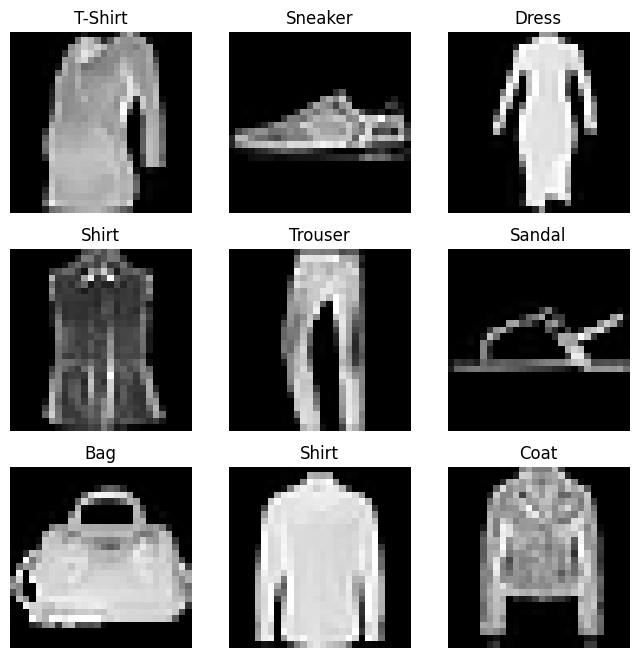

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    if i == 1:
        print(type(img), type(label))
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 创建自定义数据集

自定义的数据集类必须实现三个函数：`__init__`、`__len__` 和 `__getitem__`。请看下面的实现；FashionMNIST 图像存储在目录 `img_dir` 中，它们的标签分别存储在 CSV 文件 `annotations_file` 中。

在接下来的部分中，将分解每个函数中发生的事情。

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## `__init__`

当实例化 `Dataset` 对象时，`__init__` 函数会运行一次。初始化包含图像的目录、注解文件以及两种变换。

`labels.csv` 文件如下所示：

```
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

In [5]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

## `__len__`

`__len__` 函数返回数据集中的样本数量。

示例：

In [6]:
def __len__(self):
    return len(self.img_labels)

## `__getitem__`

`__getitem__` 函数根据给定的索引 `idx` 加载并返回数据集中的样本。该函数首先确定图像在磁盘上的位置，然后使用 `read_image` 方法将图像转换为张量。接着从 `self.img_labels` 中的 csv 数据检索相应的标签，对它们应用变换函数（如果适用），并以元组的形式返回张量图像和对应的标签。

In [7]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

## 为了训练准备数据：使用 DataLoaders

`Dataset` 类负责一次检索一个样本的数据集特征和标签。在模型训练过程中，通常希望以“小批量”的形式传递样本，并在每个周期重新打乱数据以减少模型过拟合，同时利用 Python 的 `multiprocessing` 来加速数据检索。

`DataLoader` 是可迭代对象，它通过简单的 API 抽象了这些复杂性。

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 遍历 `DataLoader`

已经将数据集加载到 `DataLoader` 中，可以根据需要遍历数据集。下面的每次迭代都会返回包含64个特征和标签的批次（分别为`train_features`和`train_labels`）。由于指定了`shuffle=True`，在遍历所有批次后，数据会被重新打乱（为了更精细地控制数据加载顺序，请查看[Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)）。

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


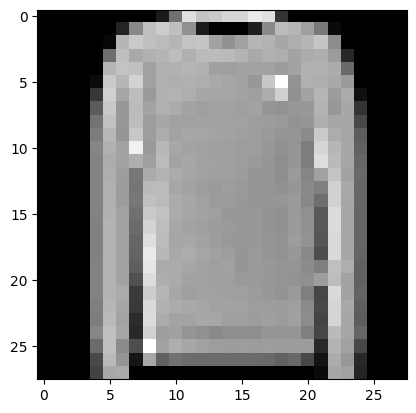

Label: 2


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

进一步阅读
===============

- [PyTorch 数据加载工具 API](https://pytorch.org/docs/stable/data.html)
